In [1]:
import os
import sys
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.4-src.zip'))
sys.path.insert(0, os.path.join(spark_home, 'python'))
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.2.1
      /_/

Using Python version 3.6.4 (default, Jan 16 2018 18:10:19)
SparkSession available as 'spark'.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
def plotdigits(X, xdim=28, ydim=28):
    n, d = X.shape
    f, axarr = plt.subplots(1, n, sharey=True)
    f.set_figwidth(10 * n)
    f.set_figheight(n)
    
    if n > 1:
        for i in range(n):
            axarr[i].imshow(X[i, :].reshape(ydim, xdim), cmap=plt.cm.binary_r)
    else:
        axarr.imshow(X[0, :].reshape(ydim, xdim), cmap=plt.cm.binary_r)

In [3]:
from mnist import MNIST
#https://pypi.python.org/pypi/python-mnist
mndata=MNIST("data/")
train_X,train_Y=mndata.load_training()
test_X,test_Y=mndata.load_testing()
train_X=np.array(train_X)
train_Y=np.array(train_Y,dtype=int).reshape((-1,1))
test_X=np.array(test_X)
test_Y=np.array(test_Y,dtype=int).reshape((-1,1))
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
train=np.concatenate([train_Y,train_X],axis=1).tolist()
test=np.concatenate([test_Y,test_X],axis=1).tolist()

(60000, 784)
(60000, 1)
(10000, 784)
(10000, 1)


array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4]])

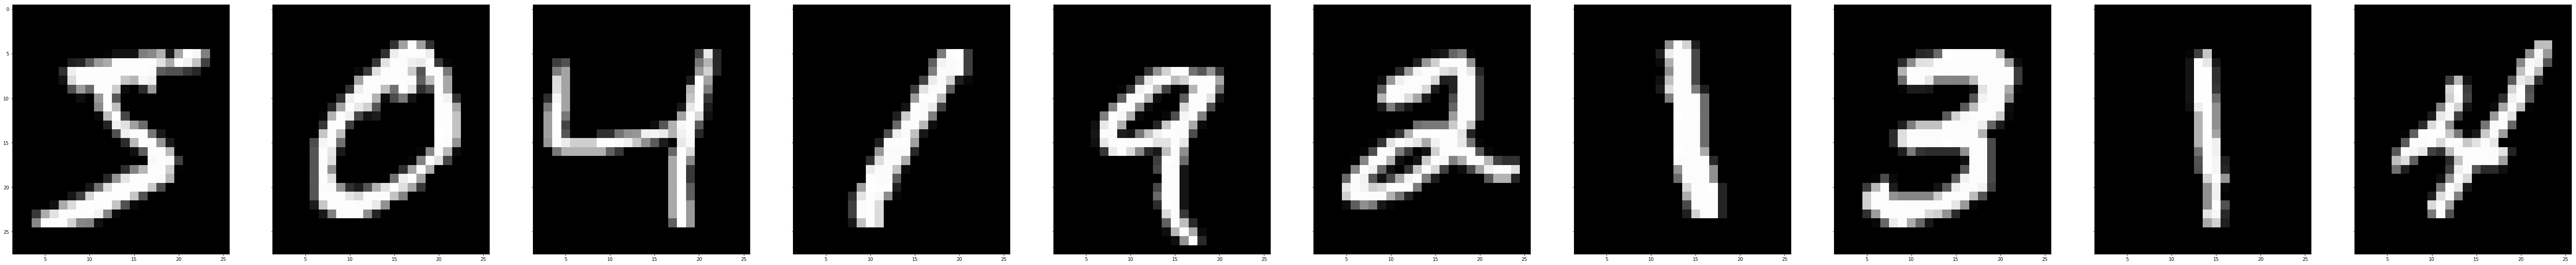

In [4]:
plotdigits(train_X[:10, :])
train_Y[:10, :]

In [5]:
def logistic(x):
    x=x-np.max(x,axis=1,keepdims=True) #avoid nan
    f=(np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True))
    return f
def create_id_matrix(Y):
    n=Y.shape[0]
    t=np.zeros((n,10))
    for i in range(10):
        t[np.where(Y==i)[0],i]=1
    return t
def gradient(data,w):
    X=data[:,1:]
    m,_=X.shape
    Y=data[:,0].reshape((-1,1))
    t=create_id_matrix(Y)
    y=logistic(np.dot(X,w))
    g=np.dot((y-t).T,X).T
    return g
def prediction(X,w):
    prob=logistic(np.dot(X,w))
    pred=np.where(prob==np.max(prob,axis=1,keepdims=True))[1]
    return pred
def accuracy(X,Y,w):
    pred=prediction(X,w).reshape((-1,1))
    acc=np.mean(pred==Y)
    return acc
def add(x,y):
    x += y
    return x
def readPointBatch(iterator):
    D = 784
    lines = list(iterator)
    matrix = np.zeros((len(lines),D+1))
    for i, line in enumerate(lines): 
         matrix[i] = np.array(line)
    return [matrix]

In [6]:
learningRate = 0.01
iterations=200
train_rdd=sc.parallelize(train).mapPartitions(readPointBatch).cache()

In [8]:
w = np.random.uniform(-10,10,28*28*10).reshape((-1,10))
for i in range(iterations):
    print("On iteration %i" % (i + 1))
    w -= learningRate*train_rdd.map(lambda m: gradient(m, w)).reduce(add)

On iteration 1
On iteration 2
On iteration 3
On iteration 4
On iteration 5
On iteration 6
On iteration 7
On iteration 8
On iteration 9
On iteration 10
On iteration 11
On iteration 12
On iteration 13
On iteration 14
On iteration 15
On iteration 16
On iteration 17
On iteration 18
On iteration 19
On iteration 20
On iteration 21
On iteration 22
On iteration 23
On iteration 24
On iteration 25
On iteration 26
On iteration 27
On iteration 28
On iteration 29
On iteration 30
On iteration 31
On iteration 32
On iteration 33
On iteration 34
On iteration 35
On iteration 36
On iteration 37
On iteration 38
On iteration 39
On iteration 40
On iteration 41
On iteration 42
On iteration 43
On iteration 44
On iteration 45
On iteration 46
On iteration 47
On iteration 48
On iteration 49
On iteration 50
On iteration 51
On iteration 52
On iteration 53
On iteration 54
On iteration 55
On iteration 56
On iteration 57
On iteration 58
On iteration 59
On iteration 60
On iteration 61
On iteration 62
On iteration 63
O

In [9]:
accuracy(train_X,train_Y,w)

0.9114333333333333

In [10]:
accuracy(test_X,test_Y,w)

0.912

[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
[[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]]


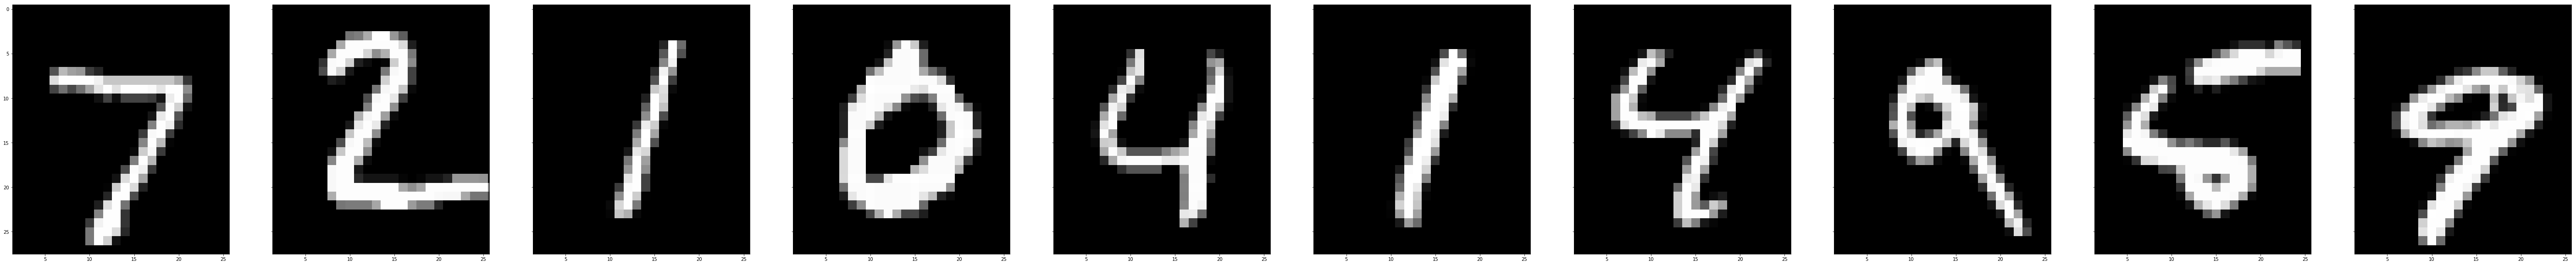

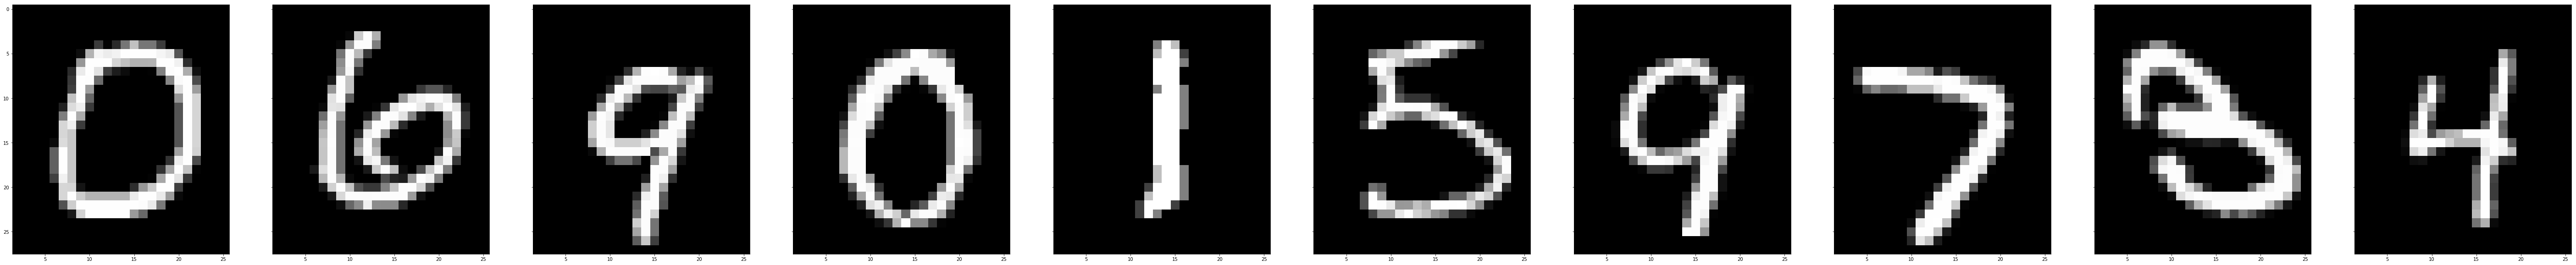

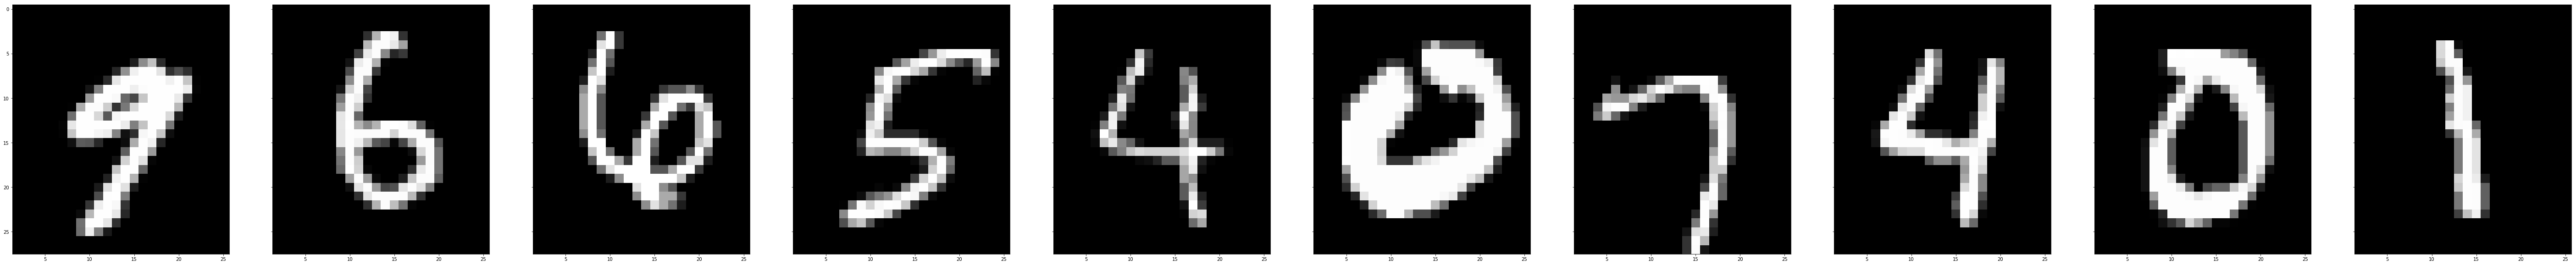

In [23]:
plotdigits(test_X[:10, :])
plotdigits(test_X[10:20, :])
plotdigits(test_X[20:30, :])
print(prediction(test_X[:30,:],w))
print(test_Y[:30,:].T)

[[5 4 3 6 2 9 7 0 2 9 3 6 8 9 3 4 1 6 8 4 7 3 2 9 2 5 6 5 9 2]]
[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


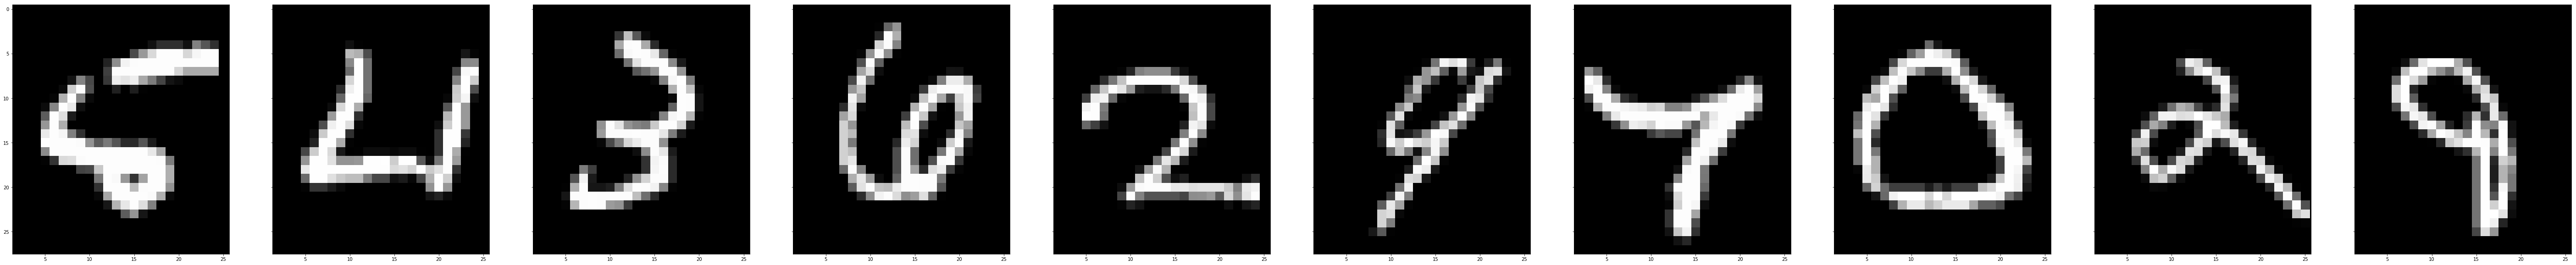

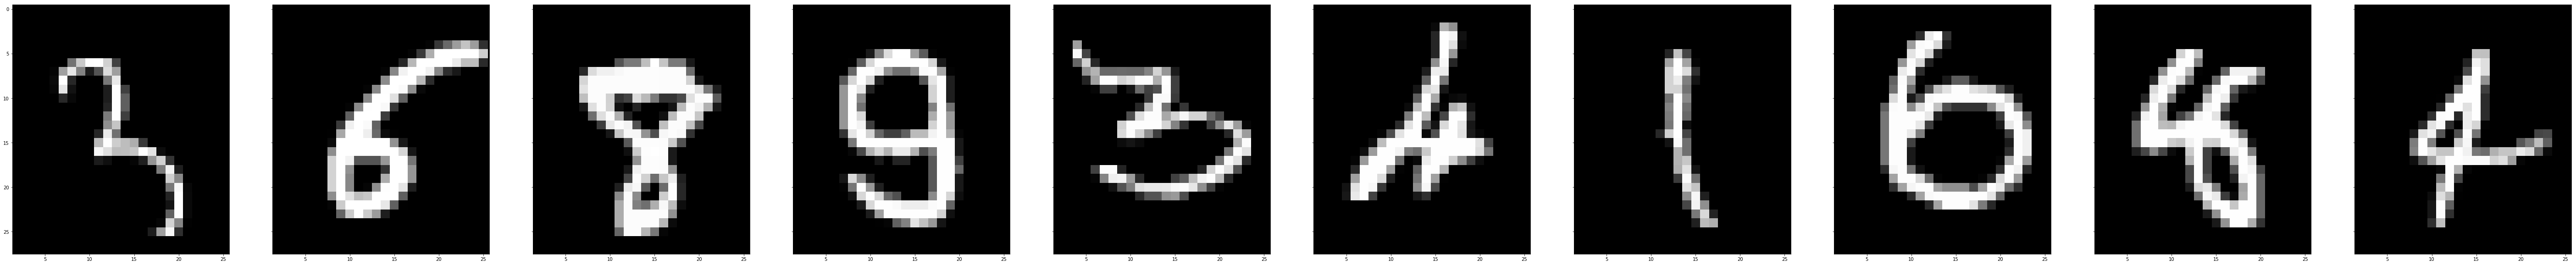

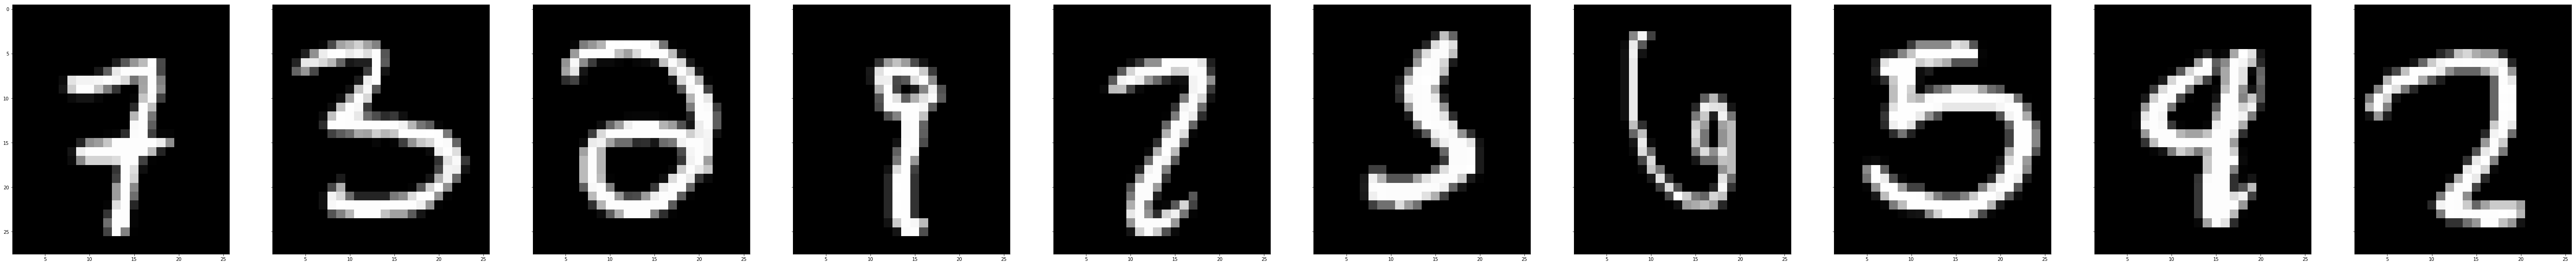

In [43]:
pred=prediction(test_X,w)
wrong=test_X[(pred!=test_Y.T)[0],:]
wrong_label=test_Y[(pred!=test_Y.T)[0],:]
plotdigits(wrong[:10, :])
plotdigits(wrong[10:20, :])
plotdigits(wrong[20:30, :])
print(wrong_label[:30,:].T)
print(pred[:30])